Stifler density over k-core

In [1]:
import csv

import networkx as nx
import numpy as np

import seaborn as sns; sns.set()
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd

from collections import Counter
from operator import itemgetter
from os import listdir
from os.path import isfile, isdir, join, exists

In [2]:
plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams['patch.force_edgecolor'] = True
plt.rcParams['font.size'] = 14

In [45]:
mypath = '../../log/'
dirs = [join(mypath, f) for f in listdir(mypath) if isdir(join(mypath,f)) and ("Graph" in f or "URV" in f)]
dirs

['../../log/EmailGraph02',
 '../../log/EmailURV',
 '../../log/EmailGraph01',
 '../../log/EmailGraph005',
 '../../log/EmailGraph001']

read all files. skip intestation rows, create an array of raw data, [k-core, stifler-density]

In [46]:
G = nx.Graph()
with open('../../src/datasets/EmailURV/EmailURV.csv', 'r') as file:
    reader = csv.reader(file, delimiter=",")
    for row in reader:
        G.add_edge(int(row[0]), int(row[1]))
N_AGENTS = len(G.nodes())

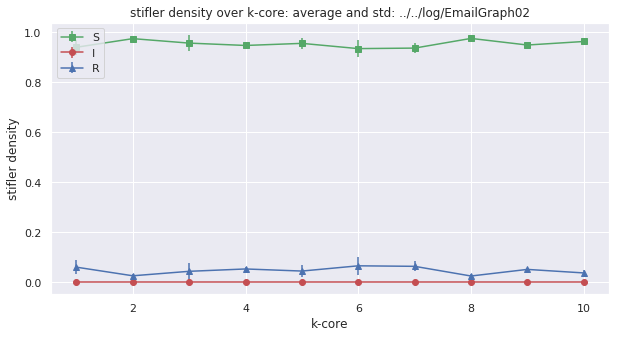

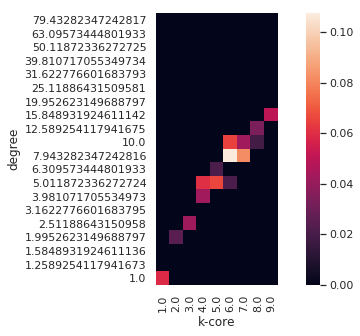

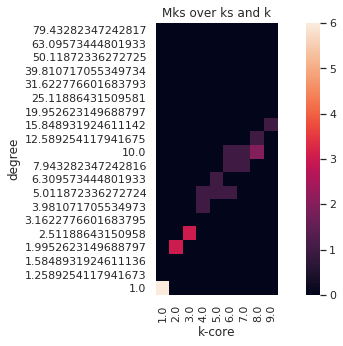

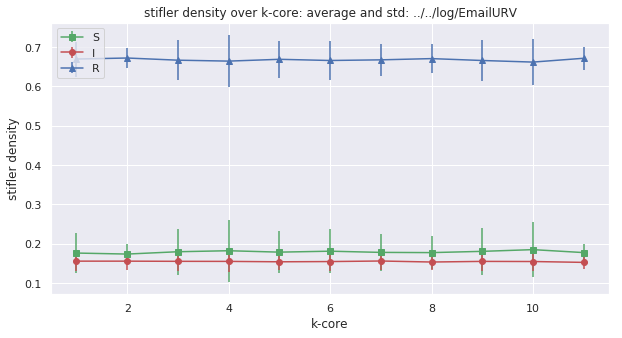

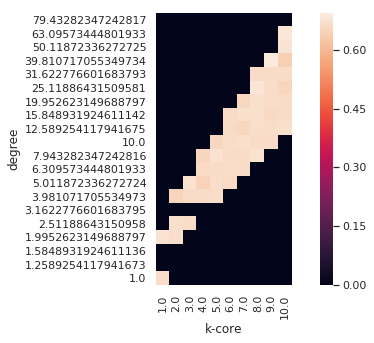

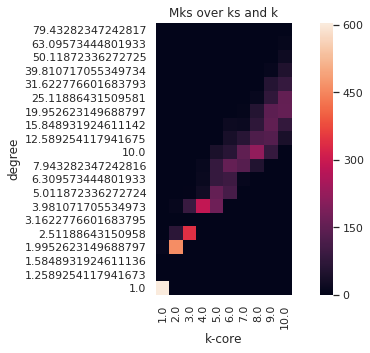

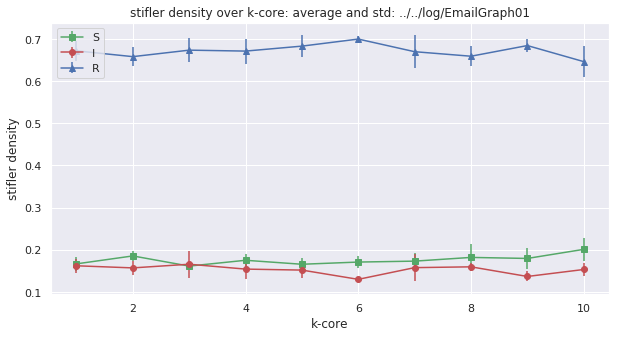

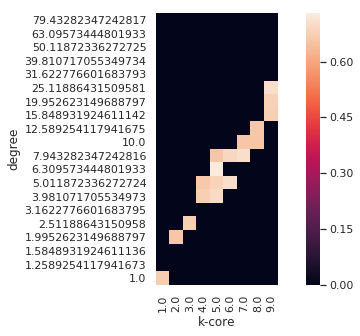

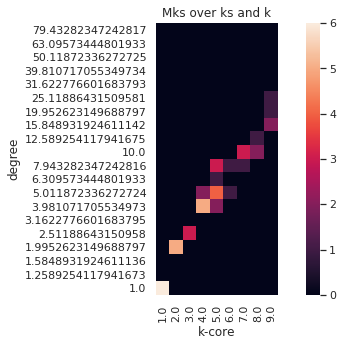

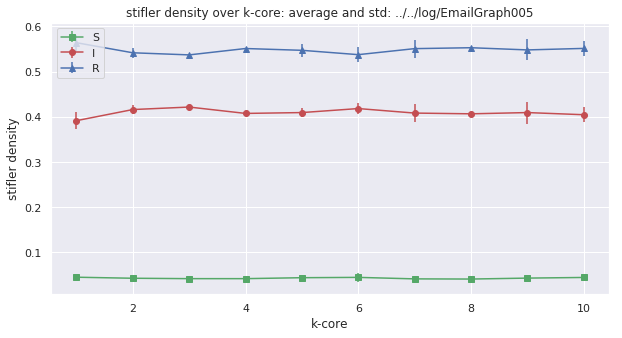

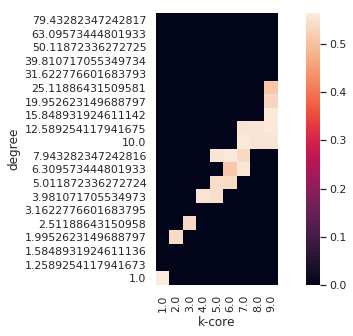

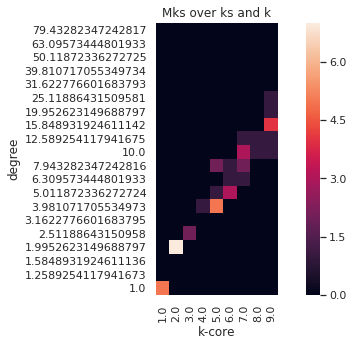

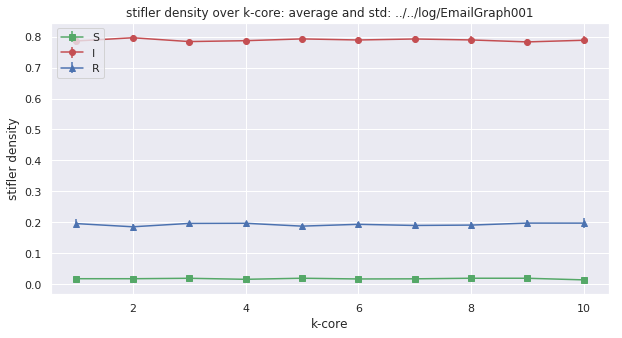

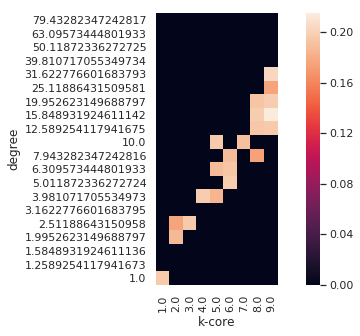

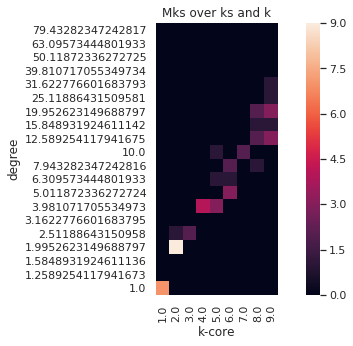

In [76]:
cleanlist_final = []
rawdataframe = pd.DataFrame()

for ddir in dirs:
    dff = pd.DataFrame()
    kdirs = [f for f in listdir(ddir) if isdir(join(ddir,f))]
    kcores = [join(join(ddir, f),'k_core.csv') for f in kdirs]
    rawdensities = []
    for index, filename in enumerate(kcores):
        s_den = 0
        i_den = 0
        r_den = 0
        k_core = 0
        degree = 0
        number = 0
        with open(filename, 'r') as file:
            reader = csv.reader(file, delimiter=",")
            for row in reader:
                if len(row) < 4:
                    continue
                try:
                    int(row[0])
                except:
                    continue
                if int(row[0]) == 1 and row[3] == 'i':
                    k_core = int(row[2])
                    number = int(row[1]) if int(row[1]) != 0 else 1 ### FIX THIS 
                    ## ERROR ON INDEX 0
                if int(row[0]) != 1:
                    if row[3] == 's':
                        s_den += 1
                    elif row[3] == 'i':
                        i_den += 1
                    elif row[3] == 'r':
                        r_den += 1
                    else:
                        print("unrecognized option", row[3])
        total = s_den +i_den + r_den
        s_den /= total
        i_den /= total
        r_den /= total
        degree = G.degree(number)
        rawdensities.append([k_core, degree, s_den, i_den, r_den])

    # clean spreading that failed
    rawdensities = [el for el in rawdensities if el[2] < 0.99]
    rawdensities = np.array(rawdensities)

    

    # sort by k-core
    rawdensities = np.array(sorted(rawdensities, key=itemgetter(0)))

    k, d, s, i, r = rawdensities.T
    rawdataframe = rawdataframe.append( pd.DataFrame(data={"k-core" : k, 
                            "degree" : d, 
                            "val" : s, 
                            "state" : ['s'] * len(k),
                            "data": [ddir] * len(k)}) )
    rawdataframe = rawdataframe.append( pd.DataFrame(data={"k-core" : k, 
                            "degree" : d, 
                            "val" : i, 
                            "state" : ['i'] * len(k),
                            "data": [ddir] * len(k)}) )
    rawdataframe = rawdataframe.append( pd.DataFrame(data={"k-core" : k, 
                            "degree" : d, 
                            "val" : r, 
                            "state" : ['r'] * len(k),
                            "data": [ddir] * len(k)}) )
    cleanlist = []
    s_sublist = []
    i_sublist = []
    r_sublist = []

    for i in range(int(max([el[0] for el in np.sort(rawdensities, axis=0)])) + 1):
        if i == 0:
            continue
        s_sublist = [el[2] for el in rawdensities if int(el[0]) == i ]
        i_sublist = [el[3] for el in rawdensities if int(el[0]) == i ]
        r_sublist = [el[4] for el in rawdensities if int(el[0]) == i ]

        cleanlist.append([
            i,
            np.mean(s_sublist),
            np.std(s_sublist),
            np.mean(i_sublist),
            np.std(i_sublist),
            np.mean(r_sublist),
            np.std(r_sublist)
        ])
        s_sublist = []
        i_sublist = []
        r_sublist = []

    fig1 = plt.figure()
    ax2 = fig1.add_subplot(111)

    k_m, s_m, s_s, i_m, i_s, r_m, r_s = np.array([el for el in cleanlist if ~np.isnan(el[1])]).T

    ax2.errorbar(k_m, s_m, yerr=s_s, fmt='gs-', label='S')
    ax2.errorbar(k_m, i_m, yerr=i_s, fmt='ro-', label='I')
    ax2.errorbar(k_m, r_m, yerr=r_s, fmt='b^-', label='R')

    plt.legend(loc='upper left')
    plt.title("stifler density over k-core: average and std: "+ddir)
    plt.ylabel("stifler density")
    plt.xlabel("k-core")
    plt.savefig("stiflerdensityoverkcore"+ddir[10:]+".pdf")
    plt.show()

    cleanlist_final.append(cleanlist)

    rawdensities = np.array(sorted(rawdensities, key=itemgetter(1)))
    rawdensities = np.array(sorted(rawdensities, key=itemgetter(0)))
    l = rawdensities.tolist()
    li = [ [int(el[0]), int(el[1]), el[2], el[3], el[4]] for el in l ]

    #
    # Filter dataframe by state == 'r'
    #
    dff = rawdataframe.loc[rawdataframe["state"] == 'r']
    dff = dff.loc[dff["data"] == ddir]
    col1 = 'k-core'
    col2 = 'degree'
    x = list(dff[col1])
    y = list(dff[col2])
    xnbins = int(max(x))
    ynbins = xnbins
    xmax = dff[col1].max()
    xmin = dff[col1].min()
    ymax = dff[col2].max()
    ymin = dff[col2].min()
    xbins = np.linspace(xmin, xmax, num=xnbins)
    ybins = np.logspace(int(np.log10(ymin)), int(np.log10(ymax)) + 1, num=21, endpoint=True)
    #ybins = np.linspace(ymin, ymax, num=ynbins + 10)
    #
    # Empty dictionary of ranges
    #
    dict = {}
    for i, el in enumerate(xbins):
        if i + 1 == len(xbins):
            continue
        for j, ll in enumerate(ybins):
            if j + 1 == len(ybins):
                continue
            dict[(xbins[i],
                  xbins[i+1],
                  ybins[j],
                  ybins[j+1])] = []
    
    #
    # Fill dict with average of M,ks,k
    #
    for key in dict:
        dict[key] = list(dff.loc[
            dff[col1] >= key[0]].loc[
            dff[col1] < key[1]].loc[
            dff[col2] >= key[2]].loc[
            dff[col2] < key[3]]['val'])
        if dict[key] == []:
            dict[key] = [0.00001]
        dict[key] = np.nanmean(dict[key])
    #
    # Clean dict and use finaldict
    #
    finaldict = {}
    for key in dict:
        if key[0] == 0:
            continue
        if key[2] == 0:
            continue
        finaldict[(key[0], key[2])] = dict[key]
    #
    # Put everything in list and create a new dataframe df
    # plot the data
    #
    kk = []
    dd = []
    rr = []
    for key in finaldict:
        kk.append(key[0])
        dd.append(key[1])
        rr.append(finaldict[key])
    df = pd.DataFrame(data={'k-core': kk, 'degree': dd, 'stiflers': rr})
    df =df.pivot("degree", "k-core", "stiflers", ).fillna(0.0001)
    df = df.iloc[::-1]
    #df = df.applymap(np.exp)
    f, ax = plt.subplots()
    sns.heatmap(df, linewidths=0, ax=ax, square=True)
    plt.show()
    
    #
    # Empty dictionary of ranges
    #
    dict = {}
    for i, el in enumerate(xbins):
        if i + 1 == len(xbins):
            continue
        for j, ll in enumerate(ybins):
            if j + 1 == len(ybins):
                continue
            dict[(xbins[i],
                  xbins[i+1],
                  ybins[j],
                  ybins[j+1])] = 0
    #
    # Fill dict with counting of M,ks,k
    #
    for key in dict:
        dict[key] = list(dff.loc[
            dff[col1] >= key[0]].loc[
            dff[col1] < key[1]].loc[
            dff[col2] >= key[2]].loc[
            dff[col2] < key[3]]['val'])
        if dict[key] == []:
            dict[key] = []
        dict[key] = len(dict[key]) + 0.00001

    #
    # Clean dict and use the finaldict
    #
    finaldict = {}
    for key in dict:
        if key[0] == 0:
            continue
        if key[2] == 0:
            continue
        finaldict[(key[0], key[2])] = dict[key]
    #
    # Put everything in list and create a new dataframe df
    # plot the data
    #
    kk = []
    dd = []
    rr = []
    for key in finaldict:
        kk.append(key[0])
        dd.append(key[1])
        rr.append(finaldict[key])
    df = pd.DataFrame(data={'k-core': kk, 'degree': dd, 'stiflers': rr})
    df =df.pivot("degree", "k-core", "stiflers", ).fillna(0.0001)
    df = df.iloc[::-1]
    #df = df.applymap(np.log)
    f, ax = plt.subplots()
    sns.heatmap(df, linewidths=0, ax=ax, square=True, )
    plt.title("Mks over ks and k")
    plt.savefig("Mksoverksandk"+ddir[10:]+".pdf")
    plt.show()

In [6]:
mybins=np.logspace(0,np.log(100),100)


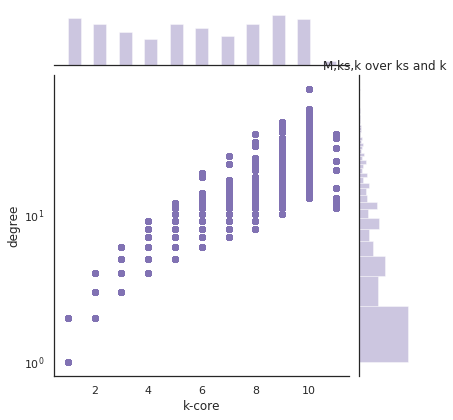

In [73]:
data = rawdataframe.loc[rawdataframe["data"] == "../../log/EmailURV"]
with sns.axes_style("white"):
    g= sns.jointplot(x="k-core", y="degree", data=data,color="m");
    ax = g.ax_joint
    ax.set_yscale('log')
    g.ax_marg_y.set_yscale('log')
    plt.title("M,ks,k over ks and k")
    plt.savefig("Mksoverksandk.pdf")

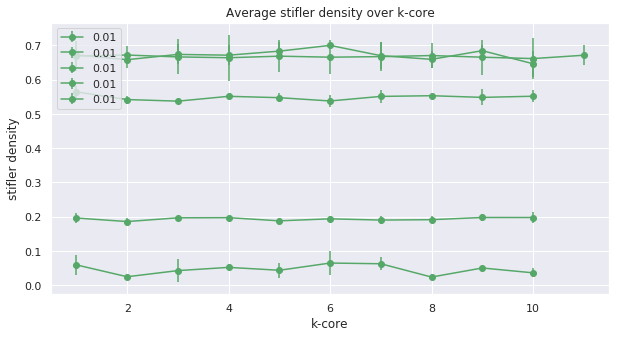

In [54]:
ffig = plt.figure()
ax3 = ffig.add_subplot(111)

for clean in cleanlist_final:
    k_m, s_m, s_s, i_m, i_s, r_m, r_s = np.array([el el in clean if ~np.isnan(el[1])]).T
    ax3.errorbar(k_m, r_m, yerr=r_s, fmt='go-', label='0.01')

    plt.legend(loc='upper left')
    plt.title("Average stifler density over k-core")
    plt.xlabel("k-core")
    plt.ylabel("stifler density")

    #plt.savefig('/home/nik/Documents/masterthesis/img/pdf/stiflerdensityoverkcore.pdf')

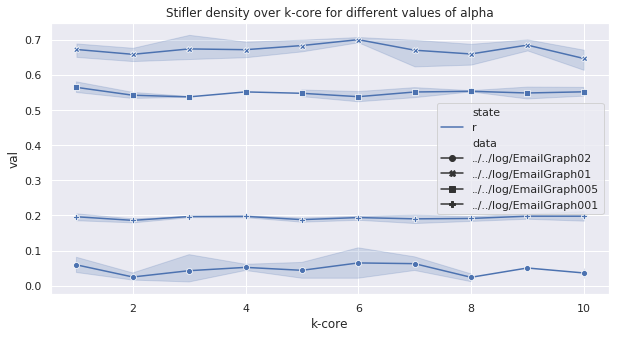

In [70]:
asdf = rawdataframe.loc[rawdataframe['state']=='r']
asdf = asdf.loc[asdf['data'] != "../../log/EmailURV"]
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
ax = sns.lineplot(x="k-core", y="val", hue="state", style="data",
                  markers=True, dashes=False,
                  data=asdf)
plt.title("Stifler density over k-core for different values of alpha")
plt.savefig("stiflerdensityoverkcorealpha.pdf")

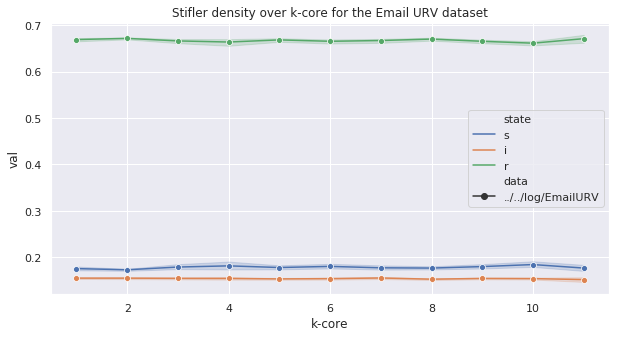

In [69]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
ax = sns.lineplot(x="k-core", y="val", hue="state", style="data",
                  markers=True, dashes=False,
                  data=data)
plt.title("Stifler density over k-core for the Email URV dataset")
plt.savefig("stiflerdensityoverkcoreurv.pdf")

In [287]:
dff = rawdataframe.loc[rawdataframe["state"] == 'r']
xnbins = 11
ynbins = 10
col1 = 'k-core'
col2 = 'degree'
x = list(dff[col1])
y = list(dff[col2])
xmax = dff[col1].max()
xmin = dff[col1].min()
ymax = dff[col2].max()
ymin = dff[col2].min()
xbins, xstep = np.linspace(xmin, xmax, num=xnbins, retstep=True)
ybins = np.logspace(int(np.log10(ymin)), int(np.log10(ymax)) + 1, num=ynbins, endpoint=True)

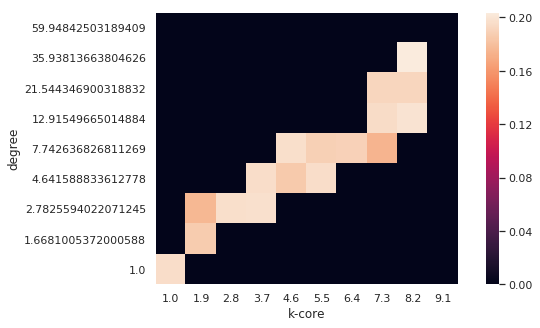

In [14]:
dict = {}
for i, el in enumerate(xbins):
    if i + 1 == len(xbins):
        continue
    for j, ll in enumerate(ybins):
        if j + 1 == len(ybins):
            continue
        dict[(xbins[i],
              xbins[i+1],
              ybins[j],
              ybins[j+1])] = []
        
for key in dict:
    dict[key] = list(dff.loc[
        dff[col1] >= key[0]].loc[
        dff[col1] < key[1]].loc[
        dff[col2] >= key[2]].loc[
        dff[col2] < key[3]]['val'])
    if dict[key] == []:
        dict[key] = [0.]
    dict[key] = np.nanmean(dict[key])
finaldict = {}
for key in dict:
    if key[0] == 0:
        continue
    if key[2] == 0:
        continue
    finaldict[(key[0], key[2])] = dict[key]


kk = []
dd = []
rr = []
for key in finaldict:
    kk.append(key[0])
    dd.append(key[1])
    rr.append(finaldict[key])


df = pd.DataFrame(data={'k-core': kk, 'degree': dd, 'stiflers': rr})
df =df.pivot("degree", "k-core", "stiflers", ).fillna(0.0001)

df = df.iloc[::-1]
#df = df.applymap(np.exp)
f, ax = plt.subplots()
sns.heatmap(df, linewidths=0, ax=ax, square=True)
plt.show()

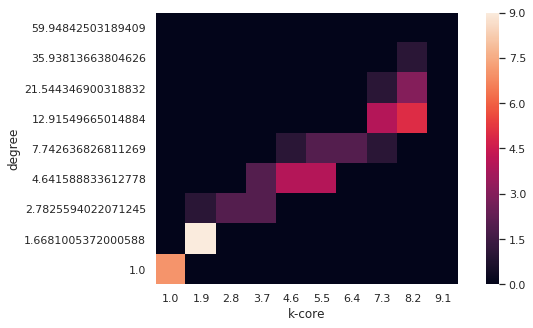

In [13]:
dict = {}
for i, el in enumerate(xbins):
    if i + 1 == len(xbins):
        continue
    for j, ll in enumerate(ybins):
        if j + 1 == len(ybins):
            continue
        dict[(xbins[i],
              xbins[i+1],
              ybins[j],
              ybins[j+1])] = 0
        
for key in dict:
    dict[key] = list(dff.loc[
        dff[col1] >= key[0]].loc[
        dff[col1] < key[1]].loc[
        dff[col2] >= key[2]].loc[
        dff[col2] < key[3]]['val'])
    if dict[key] == []:
        dict[key] = []
    dict[key] = len(dict[key])

finaldict = {}
for key in dict:
    if key[0] == 0:
        continue
    if key[2] == 0:
        continue
    finaldict[(key[0], key[2])] = dict[key]

kk = []
dd = []
rr = []
for key in finaldict:
    kk.append(key[0])
    dd.append(key[1])
    rr.append(finaldict[key])


df = pd.DataFrame(data={'k-core': kk, 'degree': dd, 'stiflers': rr})
df =df.pivot("degree", "k-core", "stiflers", ).fillna(0.0001)

df = df.iloc[::-1]
#df = df.applymap(np.exp)
f, ax = plt.subplots()
sns.heatmap(df, linewidths=0, ax=ax, square=True)
plt.show()